# Image Captioning project

In [65]:
import os  
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import spacy  
from PIL import Image
from random import shuffle
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence  

from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms

import torch.optim as optim
import torchvision.models as models
# import torchvision.transforms as T

IMG_SHAPE=(224, 224)

In [66]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Data loading

The dataset that we are using is the Viz Wiz dataset.
The original dataset contains 39,181 images with 5 captions for each one of these 
images.

Our aim is to develop a model that, given an image, returns a sentence that describes
it.

The original train dataset is too large (23,431 images). We chose to perform training on the original validation dataset (7,750 images). As the original test dataset captions are not publicly shared, we chose to perform testing on a subset of training set (1171 images). 

In [ ]:
#importing original validation dataset for train task
!wget http://ivc.ischool.utexas.edu/VizWiz_final/images/val.zip

--2022-03-27 19:10:45--  http://ivc.ischool.utexas.edu/VizWiz_final/images/val.zip
Resolving ivc.ischool.utexas.edu (ivc.ischool.utexas.edu)... 146.6.168.124
Connecting to ivc.ischool.utexas.edu (ivc.ischool.utexas.edu)|146.6.168.124|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ivc.ischool.utexas.edu/VizWiz_final/images/val.zip [following]
--2022-03-27 19:10:46--  https://ivc.ischool.utexas.edu/VizWiz_final/images/val.zip
Connecting to ivc.ischool.utexas.edu (ivc.ischool.utexas.edu)|146.6.168.124|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3488913457 (3.2G) [application/zip]
Saving to: ‘val.zip’

val.zip             100%[===================>]   3.25G  68.0MB/s    in 49s     

2022-03-27 19:11:35 (67.2 MB/s) - ‘val.zip’ saved [3488913457/3488913457]



In [77]:
#importing original training dataset for train task
!wget https://ivc.ischool.utexas.edu/VizWiz_final/images/train.zip

--2022-03-27 19:20:44--  https://ivc.ischool.utexas.edu/VizWiz_final/images/train.zip
Resolving ivc.ischool.utexas.edu (ivc.ischool.utexas.edu)... 146.6.168.124
Connecting to ivc.ischool.utexas.edu (ivc.ischool.utexas.edu)|146.6.168.124|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11298421598 (11G) [application/zip]
Saving to: ‘train.zip.1’

train.zip.1         100%[===================>]  10.52G  24.8MB/s    in 7m 19s  

2022-03-27 19:28:03 (24.6 MB/s) - ‘train.zip.1’ saved [11298421598/11298421598]



In [ ]:
#importing captions
!wget http://ivc.ischool.utexas.edu/VizWiz_final/caption/annotations.zip

--2022-03-27 19:14:15--  http://ivc.ischool.utexas.edu/VizWiz_final/caption/annotations.zip
Resolving ivc.ischool.utexas.edu (ivc.ischool.utexas.edu)... 146.6.168.124
Connecting to ivc.ischool.utexas.edu (ivc.ischool.utexas.edu)|146.6.168.124|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ivc.ischool.utexas.edu/VizWiz_final/caption/annotations.zip [following]
--2022-03-27 19:14:16--  https://ivc.ischool.utexas.edu/VizWiz_final/caption/annotations.zip
Connecting to ivc.ischool.utexas.edu (ivc.ischool.utexas.edu)|146.6.168.124|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4509069 (4.3M) [application/zip]
Saving to: ‘annotations.zip’

annotations.zip     100%[===================>]   4.30M  12.7MB/s    in 0.3s    

2022-03-27 19:14:16 (12.7 MB/s) - ‘annotations.zip’ saved [4509069/4509069]



In [ ]:
!ls

annotations.zip			sample_data  val.zip
attention_model_state_ep80.pth	train.zip


In [ ]:
#uncomment this line to unzip original validation dataset 
!unzip  val.zip -d /data/
# !rm val.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: /data/val/VizWiz_val_00005362.jpg  
  inflating: /data/val/VizWiz_val_00000655.jpg  
  inflating: /data/val/VizWiz_val_00007619.jpg  
  inflating: /data/val/VizWiz_val_00000560.jpg  
  inflating: /data/val/VizWiz_val_00006179.jpg  
  inflating: /data/val/VizWiz_val_00001237.jpg  
  inflating: /data/val/VizWiz_val_00002140.jpg  
  inflating: /data/val/VizWiz_val_00004657.jpg  
  inflating: /data/val/VizWiz_val_00003802.jpg  
  inflating: /data/val/VizWiz_val_00002654.jpg  
  inflating: /data/val/VizWiz_val_00007634.jpg  
  inflating: /data/val/VizWiz_val_00005805.jpg  
  inflating: /data/val/VizWiz_val_00003136.jpg  
  inflating: /data/val/VizWiz_val_00001491.jpg  
  inflating: /data/val/VizWiz_val_00002377.jpg  
  inflating: /data/val/VizWiz_val_00001959.jpg  
  inflating: /data/val/VizWiz_val_00004036.jpg  
  inflating: /data/val/VizWiz_val_00004024.jpg  
  inflating: /data/val/VizWiz_val_00005079.jpg  
  inflating: /data/val/VizWiz_val

In [ ]:
#unziping original validation dataset captions
!unzip annotations.zip -d /captions
# !rm annotations.zip

Archive:  annotations.zip
   creating: /captions/annotations/
  inflating: /captions/annotations/test.json  
  inflating: /captions/annotations/val.json  
  inflating: /captions/annotations/train.json  


In [85]:
#uncomment this line to unzip original training dataset 

!unzip  train.zip -d /data

Streaming output truncated to the last 5000 lines.
  inflating: /data/train/VizWiz_train_00016897.jpg  
  inflating: /data/train/VizWiz_train_00022049.jpg  
  inflating: /data/train/VizWiz_train_00010269.jpg  
  inflating: /data/train/VizWiz_train_00001449.jpg  
  inflating: /data/train/VizWiz_train_00004288.jpg  
  inflating: /data/train/VizWiz_train_00011536.jpg  
  inflating: /data/train/VizWiz_train_00003138.jpg  
  inflating: /data/train/VizWiz_train_00000748.jpg  
  inflating: /data/train/VizWiz_train_00007422.jpg  
  inflating: /data/train/VizWiz_train_00014674.jpg  
  inflating: /data/train/VizWiz_train_00004900.jpg  
  inflating: /data/train/VizWiz_train_00022766.jpg  
  inflating: /data/train/VizWiz_train_00010259.jpg  
  inflating: /data/train/VizWiz_train_00005425.jpg  
  inflating: /data/train/VizWiz_train_00011918.jpg  
  inflating: /data/train/VizWiz_train_00008013.jpg  
  inflating: /data/train/VizWiz_train_00009540.jpg  
  inflating: /data/train/VizWiz_train_00013833.j

In [67]:
dataset = json.load(open('/captions/annotations/val.json', 'r'))
images_df = pd.DataFrame(dataset['images'])
images_df = images_df[images_df['text_detected']==True]

In [68]:
annotations_df = pd.DataFrame(dataset['annotations'])
annotations_df = annotations_df[annotations_df['is_precanned']==False]
annotations_df = annotations_df[annotations_df['is_rejected']==False]
annotations_df = annotations_df[annotations_df['text_detected']==True]

In [69]:
merged_df = pd.merge(images_df, annotations_df, left_on='id', right_on='image_id', how='inner')
merged_df = merged_df[['file_name', 'image_id', 'caption']]
merged_df.head(3)

,file_name,image_id,caption
0,VizWiz_val_00000000.jpg,23431,A computer screen shows a repair prompt on the...
1,VizWiz_val_00000000.jpg,23431,a computer screen with a repair automatically ...
2,VizWiz_val_00000000.jpg,23431,partial computer screen showing the need of re...


In [70]:
img_path = '/data/val/'
def show_img_caption(df, id):
  fig = plt.figure()
  captions = df[df['image_id']==id]
  file_name = captions['file_name'].reset_index(drop=True).iloc[0]
  im = Image.open(img_path + file_name).convert("RGB")
  plt.imshow(im)
  fig.text(.1,-.3, '\n\n '.join(captions['caption'].apply(lambda s: '-' + s).values))
  plt.show()

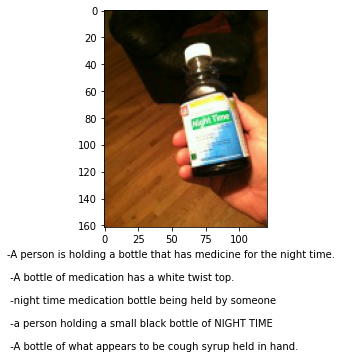

In [71]:
show_img_caption(merged_df, 23432)

## Defining Vocabulary class

In [72]:
# We will use the English spacy tokenizer
spacy_eng = spacy.load("en")

In [ ]:
class Vocabulary:
    def __init__(self, freq_thresh=5):
        self.i2w = {}
        self.w2i = {}
        self.freq_thresh = freq_thresh

    def __len__(self):
        return len(self.i2w)

    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

    def build_vocabulary(self, caption_list):
        freq_dict = {}
        idx = 4

        for sentence in caption_list:
            for word in self.tokenizer_eng(sentence):
                if word not in freq_dict:
                    freq_dict[word] = 1

                else:
                    freq_dict[word] += 1

        filtered_words = {k:v for k,v in freq_dict.items() if v >= self.freq_thresh}
        self.w2i = {k: i+idx for i,k in enumerate(filtered_words.keys())}
        self.i2w = {v:k for k,v in self.w2i.items()}
        self.i2w.update({0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"})
        self.w2i.update({"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3})
                

    def numericalize(self, caption):
        token_cap = self.tokenizer_eng(caption)

        return [self.w2i[word] if word in self.w2i else self.w2i["<UNK>"] for word in token_cap]


## Defining the Vizwiz Dataset class

In [ ]:
class VizwizDataset(Dataset):
    def __init__(self, 
                 merged_df,
                 img_path='/data/val/' ,
                 transform=None, freq_thresh=5):

        self.img_path = img_path
        self.df = merged_df
        self.transform = transform


        # Initialize vocabulary and build vocab
        self.vocab = Vocabulary(freq_thresh)
        self.vocab.build_vocabulary(self.df.caption.values)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):

        caption = self.df["caption"].iloc[index]
        img_file = self.df["file_name"].iloc[index]
       
        img = Image.open(os.path.join(self.img_path, img_file)).convert("RGB")
        if self.transform is not None:
            img = self.transform(img)

        numericalized_caption = [self.vocab.w2i["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.w2i["<EOS>"])

        return img, torch.tensor(numericalized_caption)

## Defining pad batch class and the dataloader


In [ ]:
class pad_batch():
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=True, padding_value=self.pad_idx)

        return imgs, targets

In [ ]:
transform = transforms.Compose(
        [
            transforms.Resize((356, 356)),
            transforms.RandomCrop(IMG_SHAPE),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )



vizdataset = VizwizDataset(merged_df, transform=transform)

data_loader = DataLoader(dataset=vizdataset,
                    batch_size=64,
                    num_workers=2,
                    shuffle=True,
                    collate_fn=pad_batch(pad_idx=vizdataset.vocab.w2i["<PAD>"]),
    )

## The Model Architecture

Our captioning Model is Seq2Seq model. The **Encoder** uses a pretrained CNN (ResNet model) to extract the features. The **Decoder**, is composed of **LSTM** and also uses attention mechanism between the feature maps produced by the encoder and the decoder hidden states. More specifically, we used an implementation of the Bahdanau Attention Decoder.

### Encoder

The encoder takes as input an 224x224 image and produces 49 feature maps, each one of size 2048.

In [ ]:
class EncoderCNN(nn.Module):
    def __init__(self):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        

    def forward(self, images):
        features = self.resnet(images)                                    #(batch_size,2048,7,7)
        features = features.permute(0, 2, 3, 1)                           #(batch_size,7,7,2048)
        features = features.view(features.size(0), -1, features.size(-1)) #(batch_size,49,2048)
        return features

Bahdanau Attention block. 
- The forward method of this layer takes as input the encoder feature maps as well as the current decoder hidden state and return the attention weights and the produced context vector.

In [ ]:
class Attention(nn.Module):

    def __init__(self, encoder_dim,decoder_dim,attention_dim):
        super(Attention, self).__init__()
        
        self.attention_dim = attention_dim
        
        self.W = nn.Linear(decoder_dim,attention_dim)
        self.U = nn.Linear(encoder_dim,attention_dim)
        
        self.A = nn.Linear(attention_dim,1)
        
        
        
        
    def forward(self, features, hidden_state):
        u_hs = self.U(features)     #(batch_size,num_layers,attention_dim)
        w_ah = self.W(hidden_state) #(batch_size,attention_dim)
        
        combined_states = torch.tanh(u_hs + w_ah.unsqueeze(1)) #(batch_size,num_layers,attemtion_dim)
        
        attention_scores = self.A(combined_states)         #(batch_size,num_layers,1)
        attention_scores = attention_scores.squeeze(2)     #(batch_size,num_layers)
        
        
        alpha = F.softmax(attention_scores,dim=1)          #(batch_size,num_layers)
        
        attention_weights = features * alpha.unsqueeze(2)  #(batch_size,num_layers,features_dim)
        attention_weights = attention_weights.sum(dim=1)   #(batch_size,num_layers)
        
        return alpha,attention_weights

### Decoder

The decoder has an LSTM-based architecture enriched with attention mechanism. At each decoding step, the decoder receives a context vector resulting from the interaction between its current hidden state and all the encoder hidden states. To initialize the LSTM hidden state and cell memory, we average the encoder feature maps.

In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        
        #save the model param
        self.vocab_size = vocab_size
        self.attention_dim = attention_dim
        self.decoder_dim = decoder_dim
        
        self.embedding = nn.Embedding(vocab_size,embed_size)
        self.attention = Attention(encoder_dim,decoder_dim,attention_dim)
        
        
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  
        self.lstm_cell = nn.LSTMCell(embed_size+encoder_dim,decoder_dim,bias=True)
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)
        
        
        self.fcn = nn.Linear(decoder_dim,vocab_size)
        self.drop = nn.Dropout(drop_prob)
        
        
    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)
        return h, c    
    
    def forward(self, features, captions):
        
        #vectorize the caption
        embeds = self.embedding(captions)
        
        # Initialize LSTM state
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)
        
        #get the seq length to iterate
        seq_length = len(captions[0])-1 #Exclude the last one
        batch_size = captions.size(0)
        num_features = features.size(1)
        
        preds = torch.zeros(batch_size, seq_length, self.vocab_size).to(device)
        alphas = torch.zeros(batch_size, seq_length,num_features).to(device)
                
        for s in range(seq_length):
            alpha,context = self.attention(features, h)
            lstm_input = torch.cat((embeds[:, s], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
                    
            output = self.fcn(self.drop(h))
            
            preds[:,s] = output
            alphas[:,s] = alpha  
        
        
        return preds, alphas
    
    def generate_caption(self,features,max_len=20,vocab=None):
        '''
        Inference part
        Given the image features generate the captions

        '''
        
        batch_size = features.size(0)
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)
        
        alphas = []
        
        #starting input
        word = torch.tensor(vocab.w2i['<SOS>']).view(1,-1).to(device)
        embeds = self.embedding(word)

        
        captions = []
        
        for i in range(max_len):
            alpha,context = self.attention(features, h)
            
            
            #store the apla score
            alphas.append(alpha.cpu().detach().numpy())
            
            lstm_input = torch.cat((embeds[:, 0], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            output = self.fcn(self.drop(h))
            output = output.view(batch_size,-1)
        
            
            #select the word with most val
            predicted_word_idx = output.argmax(dim=1)
            
            #save the generated word
            captions.append(predicted_word_idx.item())
            
            #end if <EOS detected>
            if vocab.i2w[predicted_word_idx.item()] == "<EOS>":
                break
            
            #send generated word as the next caption
            embeds = self.embedding(predicted_word_idx.unsqueeze(0))
        
        #covert the vocab idx to words and return sentence
        return [vocab.i2w[idx] for idx in captions],alphas
    



### Whole Architecture: Encoder + Decoder

Finally, we put all the previous blocks together to build our final model.

In [ ]:
class EncoderDecoder(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        self.encoder = EncoderCNN()
        self.decoder = DecoderRNN(
            embed_size=embed_size,
            vocab_size = len(vizdataset.vocab),
            attention_dim=attention_dim,
            encoder_dim=encoder_dim,
            decoder_dim=decoder_dim
        )
        
    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs


## Model

In [ ]:
#Defining the Hyperparameters
embed_size=300
vocab_size = len(vizdataset.vocab)
attention_dim=256
encoder_dim=2048
decoder_dim=512
learning_rate = 3e-4


In [ ]:
#init model
model = EncoderDecoder(
    embed_size=embed_size,
    vocab_size = vocab_size,
    attention_dim=attention_dim,
    encoder_dim=encoder_dim,
    decoder_dim=decoder_dim
).to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
# Defining the loss and the optimizer
criterion = nn.CrossEntropyLoss(ignore_index=vizdataset.vocab.w2i["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

## Training or loading pretrained model

You can choose whether to load a trained model weights or train a new model. We made 3 training checkpoints which we made available here: https://drive.google.com/drive/folders/1cpSWwWRYtvuLwaElMz5EwepsBygWkdev

In [ ]:
!ls

annotations.zip			sample_data  val.zip
attention_model_state_ep80.pth	train.zip


In [ ]:
## Loading previous model weights: uncomment the next line

model.load_state_dict(torch.load('attention_model_state_ep80.pth'))

RuntimeError: ignored

=======> epoch1


 47%|████▋     | 49/104 [02:21<02:36,  2.85s/it]

Epoch: 1 loss: 3.44181


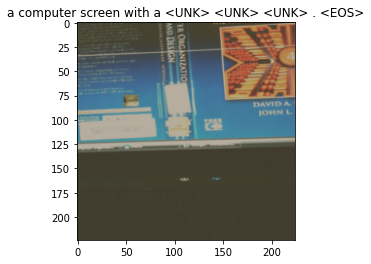

 95%|█████████▌| 99/104 [04:52<00:14,  2.85s/it]

Epoch: 1 loss: 3.39447


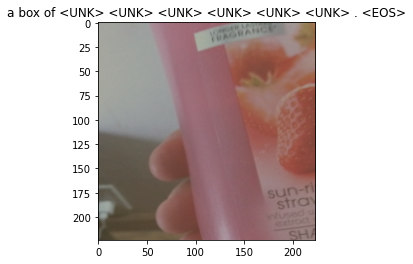

=======> epoch2


 47%|████▋     | 49/104 [02:18<02:25,  2.65s/it]

Epoch: 2 loss: 3.64904


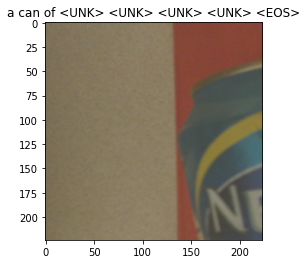

 95%|█████████▌| 99/104 [04:46<00:12,  2.59s/it]

Epoch: 2 loss: 3.43795


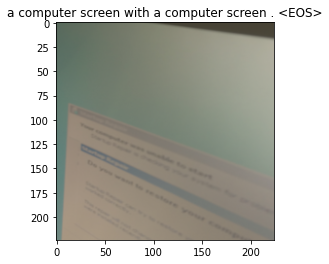

=======> epoch3


 47%|████▋     | 49/104 [02:22<02:36,  2.85s/it]

Epoch: 3 loss: 3.53036


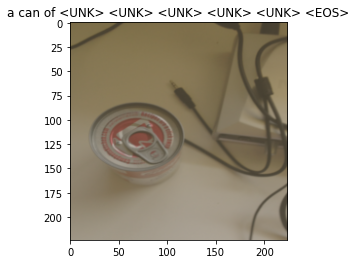

 95%|█████████▌| 99/104 [04:50<00:15,  3.02s/it]

Epoch: 3 loss: 3.37966


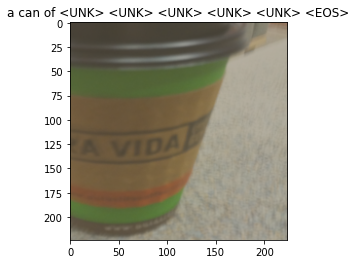

=======> epoch4


 15%|█▌        | 16/104 [00:47<03:43,  2.54s/it]

In [ ]:
%%time

num_epochs = 20
print_every = 50

for epoch in range(1,num_epochs+1): 
    print(f'=======> epoch{epoch}')
    for idx, (image, captions) in tqdm(enumerate(iter(data_loader)), total=len(data_loader), leave=False):
        image,captions = image.to(device),captions.to(device)

        # Zero the gradients.
        optimizer.zero_grad()

        # Feed forward
        outputs,attentions = model(image, captions)

        # Calculate the batch loss.
        targets = captions[:,1:]
        loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))
        
        # Backward pass.
        loss.backward()

        # Update the parameters in the optimizer.
        optimizer.step()

        if (idx+1)%print_every == 0:
            print("Epoch: {} loss: {:.5f}".format(epoch,loss.item()))
            
            
            #generate the caption
            model.eval()
            with torch.no_grad():
                dataiter = iter(data_loader)
                img,_ = next(dataiter)
                features = model.encoder(img[0:1].to(device))
                caps,alphas = model.decoder.generate_caption(features,vocab=vizdataset.vocab)
                caption = ' '.join(caps)
                show_image(img[0],title=caption)
                
            model.train()

        #save the  model
        torch.save(model.state_dict(),'attention_model_state.pth')

## Visualizing the attention weights
Defining helper functions
<li>Given the image generate captions and attention scores</li>
<li>Plot the attention scores in the image</li>

In [ ]:
def show_image(img, title=None):
    """Imshow for Tensor."""
    
    #unnormalize 
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    
    
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [ ]:
#generate caption
def get_caps_from(features_tensors, show=True):
    #generate the caption
    model.eval()
    with torch.no_grad():
        features = model.encoder(features_tensors.to(device))
        caps,alphas = model.decoder.generate_caption(features,vocab=vizdataset.vocab)
        caption = ' '.join(caps)
        if show:
            show_image(features_tensors[0],title=caption)
    
    return caps,alphas

#Show attention
def plot_attention(img, result, attention_plot):
    #untransform
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    temp_image = img

    fig = plt.figure(figsize=(15, 15))

    len_result = len(result)
    for l in range(len_result):
        temp_att = attention_plot[l].reshape(7,7)
        
        ax = fig.add_subplot(len_result//2,len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.7, extent=img.get_extent())
        

    plt.tight_layout()
    plt.show()

In [ ]:
images,_ = next(dataiter)

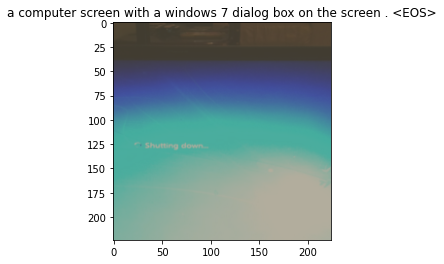

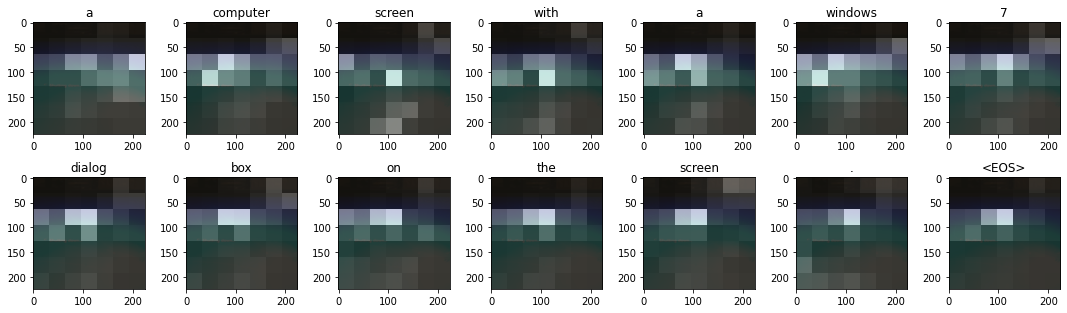

In [ ]:
#show any 1
dataiter = iter(data_loader)
images,_ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)

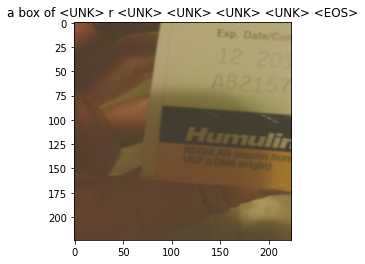

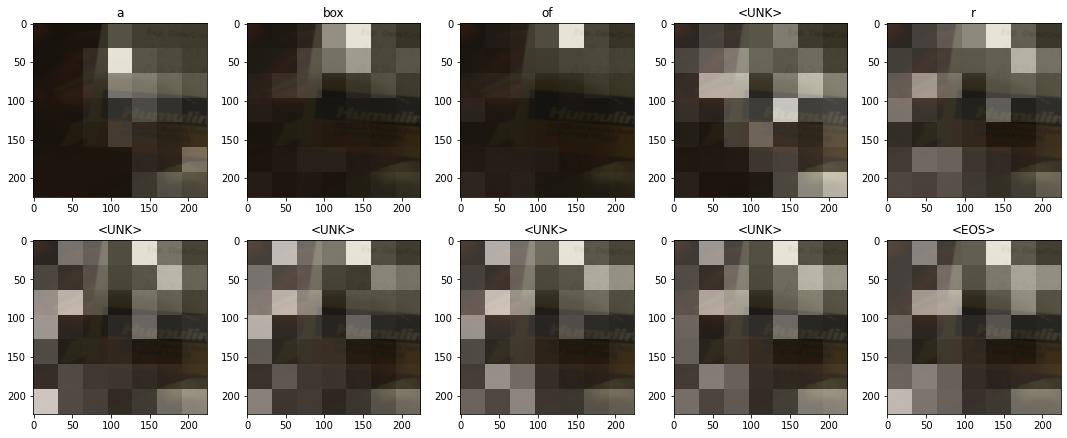

In [ ]:
#show any 1
dataiter = iter(data_loader)
images,_ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)

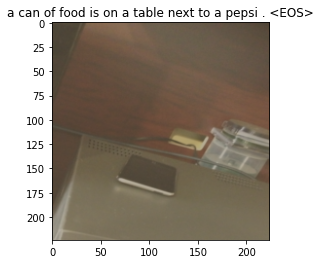

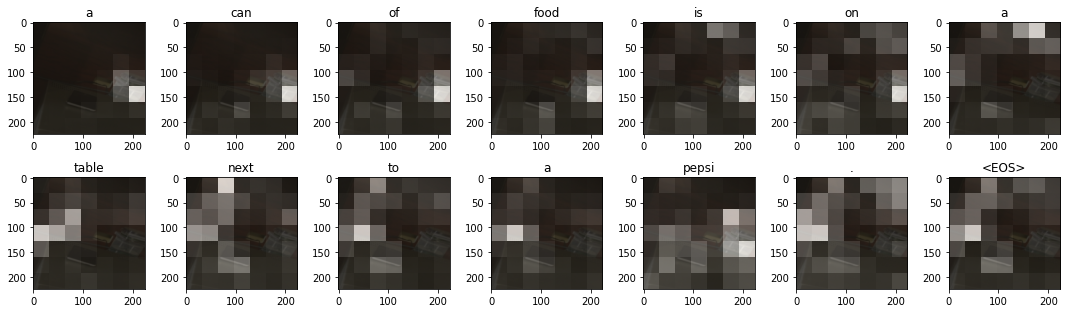

In [74]:
#show any 1
dataiter = iter(data_loader)
images,_ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)

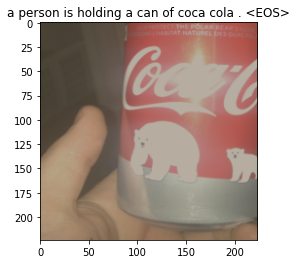

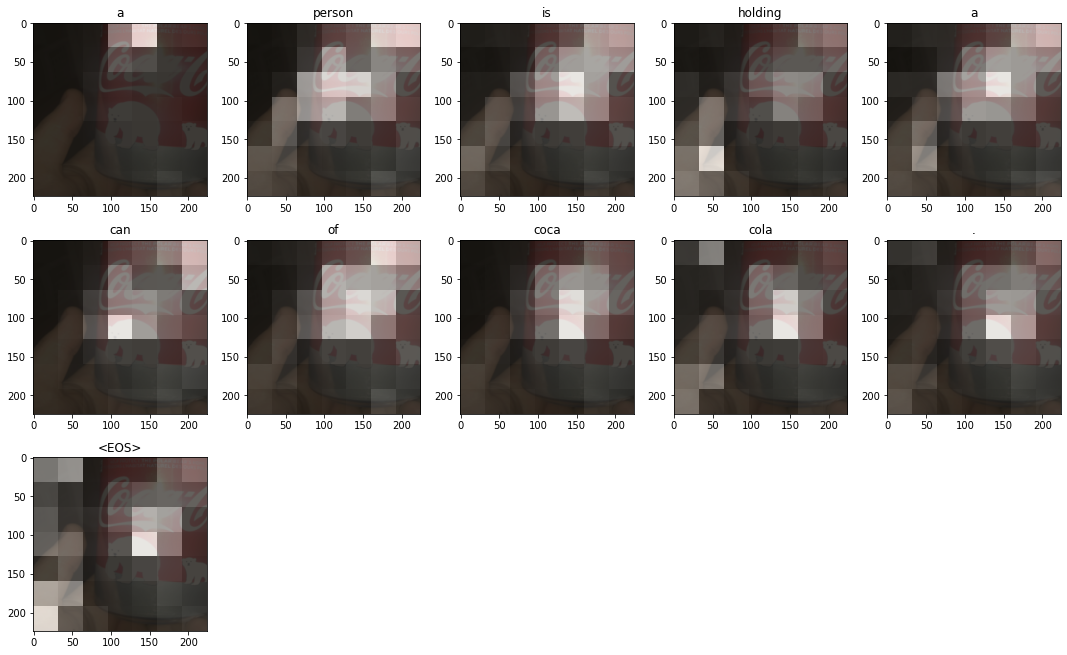

In [73]:
#show any 1
dataiter = iter(data_loader)
images,_ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)

## Testing on new images

In [86]:
dataset_train = json.load(open('/captions/annotations/train.json', 'r'))
images_df_train = pd.DataFrame(dataset_train['images'])
images_df_train = images_df_train[images_df_train['text_detected']==True]

In [87]:
annotations_df_train = pd.DataFrame(dataset_train['annotations'])
annotations_df_train = annotations_df_train[annotations_df_train['is_precanned']==False]
annotations_df_train = annotations_df_train[annotations_df_train['is_rejected']==False]
annotations_df_train = annotations_df_train[annotations_df_train['text_detected']==True]

In [88]:
merged_df_train = pd.merge(images_df_train, annotations_df_train, left_on='id', right_on='image_id', how='inner')
merged_df_train = merged_df_train[['file_name', 'image_id', 'caption']]
merged_df_train

,file_name,image_id,caption
0,VizWiz_train_00000000.jpg,0,ITS IS A BASIL LEAVES CONTAINER ITS CONTAINS T...
1,VizWiz_train_00000000.jpg,0,A green and white plastic condiment bottle con...
2,VizWiz_train_00000000.jpg,0,A bottle of spices in a plastic container layi...
3,VizWiz_train_00000000.jpg,0,some basil leaves in a container on a counter
4,VizWiz_train_00000001.jpg,1,A can of Coca Cola on a counter is shown for w...
...,...,...,...
64046,VizWiz_train_00023430.jpg,23430,The back of a plastic card such as a credit ca...
64047,VizWiz_train_00023430.jpg,23430,A card is seen with a scratch strip to reveal ...
64048,VizWiz_train_00023430.jpg,23430,The back of a gift card without the silver str...
64049,VizWiz_train_00023430.jpg,23430,The back of a plastic money or credit card wit...


In [124]:
imgs_list_train = merged_df_train['file_name'].unique()
shuffle(imgs_list_train)
img_subset_test = imgs_list_train[:int(0.01 * len(imgs_list_train))]
merged_subset_test = merged_df_train[merged_df_train['file_name'].isin(img_subset_test)]
print(merged_subset_test.shape)

(626, 3)


In [93]:
transform_test = transforms.Compose(
        [
            transforms.Resize(IMG_SHAPE),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

In [ ]:
# We use the nltk implementation if the blue score
# in order to evaluate the predictions quality
from nltk.translate import bleu_score

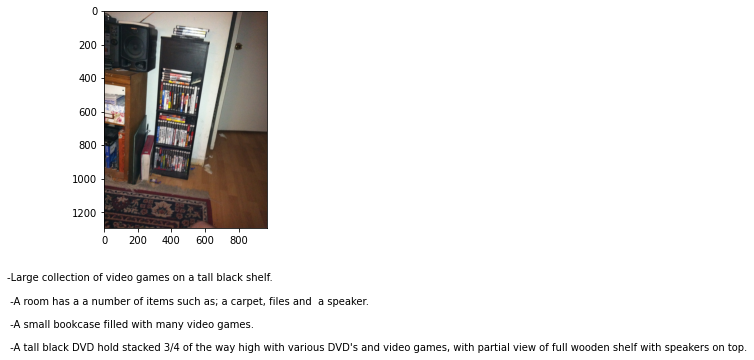

Model prediction: a black <UNK> television placed on a wooden table
Blue score:  0.515


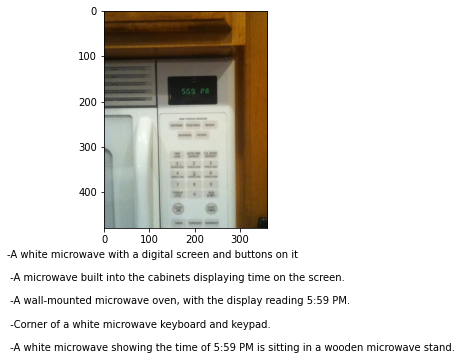

Model prediction: a white microwave with a digital display on the display .
Blue score:  0.838


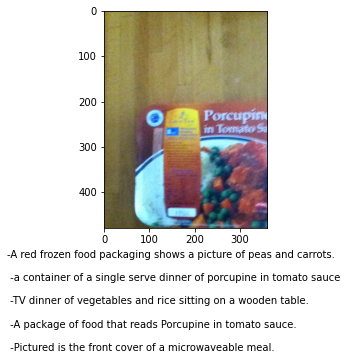

Model prediction: a box of traditional baked turkey <UNK> on a wooden table .
Blue score:  0.484


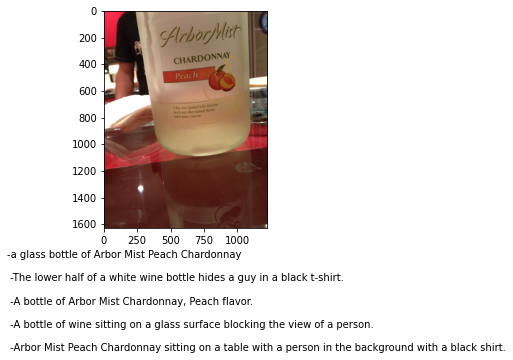

Model prediction: a bottle of <UNK> brand mango hand sanitizer
Blue score:  0.38


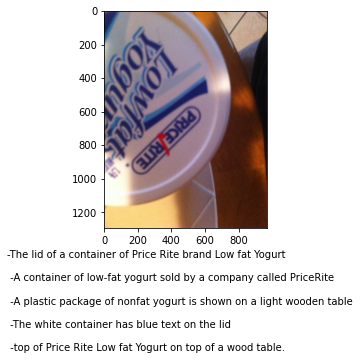

Model prediction: a white plastic container of <UNK> <UNK> <UNK> yogurt
Blue score:  0.576


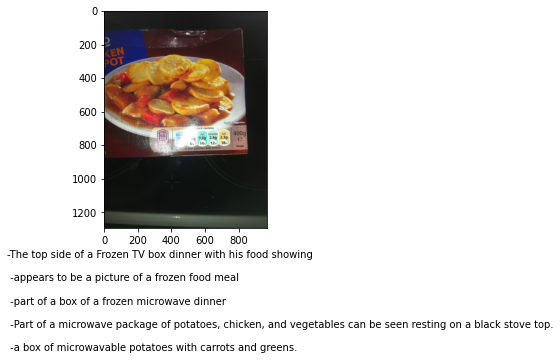

Model prediction: a box of baked pasta <UNK> in a box
Blue score:  0.354


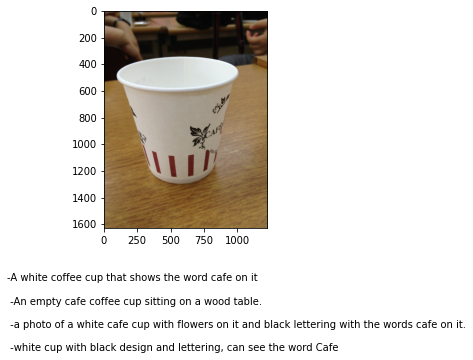

Model prediction: a mug with a cup on the outside of a dog .
Blue score:  0.468


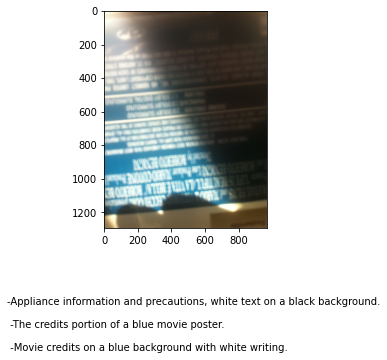

Model prediction: a computer keyboard is in a dark room with a table .
Blue score:  0.257


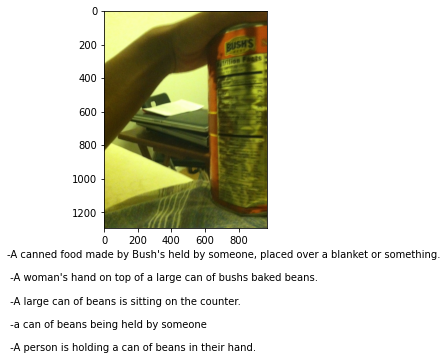

Model prediction: a can of food is on top of a table .
Blue score:  0.766


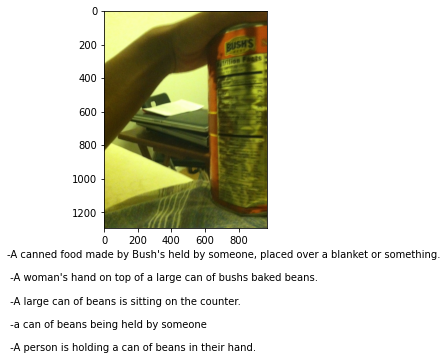

Model prediction: a can of food is on top of a table .
Blue score:  0.766


In [128]:
def show_prediction(img_path='/data/train/', df=merged_subset_test):
    fig = plt.figure()
    random_image = np.random.choice(img_subset_test)
    im = Image.open(img_path + 	random_image).convert("RGB")
    target_captions = df[df['file_name']==random_image]
    caps,alphas = get_caps_from(transform_test(im).unsqueeze(0), show=False)
    pred_caption = ' '.join(caps[:-1])
    plt.imshow(im)
    fig.text(.1,-.3, '\n\n '.join(target_captions['caption'].
                                  apply(lambda s: '-' + s).
                                  values ))
    
    
    plt.show()
    print('Model prediction: ' + pred_caption)
    blue_score = bleu_score.sentence_bleu(references= target_captions['caption'].values,
                                   hypothesis = pred_caption)
    print("Blue score: ", round(blue_score, 3))


for _ in range(10):
  show_prediction()

In [126]:
img_path='/data/train/'
blue_score_avg = 0
for img in tqdm(img_subset_test):
  im = Image.open(img_path + 	img).convert("RGB")
  target_captions = merged_subset_test[merged_subset_test['file_name']==img]
  caps,alphas = get_caps_from(transform_test(im).unsqueeze(0), show=False)
  pred_caption = ' '.join(caps[:-1])
  blue_score = bleu_score.sentence_bleu(references= target_captions['caption'].values,
                                   hypothesis = pred_caption)
  blue_score_avg += blue_score
print('Average blue score: ', blue_score_avg/ len(img_subset_test))

  2%|▏         | 3/146 [00:00<00:14, 10.12it/s]/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
100%|██████████| 146/146 [00:13<00:00, 11.08it/s]

Average blue score:  0.4795525680152152
